# Likelihood Experiment: Random Masking Analysis

This experiment analyzes how note event likelihoods vary under different random maskings.


In [1]:
import torch
import numpy as np
import symusic
import matplotlib.pyplot as plt
import einops
from pathlib import Path
import torch.nn.functional as F

from slm.load_model_util import load_model
from slm.conversion_utils import sm_to_events
from slm.masking import random_superposition


In [2]:
# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_MASKINGS = 100
MIDI_PATH = "../assets/drums_bass_piano.mid"

print(f"Device: {DEVICE}")


Device: cuda


## Load Model and MIDI File


In [3]:
# Load the model
print("Loading model...")
model = load_model(model_type="slm_mixed", epochs=150, device=DEVICE)
tokenizer = model.tokenizer
print("Model loaded!")


Loading model...
Loading model from /root/.cache/slm/slm_mixed_150epochs.ckpt...
Model loaded!


In [4]:
# Load and tokenize the MIDI file
print(f"Loading MIDI from {MIDI_PATH}...")
sm = symusic.Score(MIDI_PATH)
print(f"MIDI loaded: {len(sm.tracks)} tracks, duration: {sm.end()} ticks")

# Convert to events and encode
events = sm_to_events(sm, tag="pop", tokenizer=tokenizer)
print(f"Number of events: {len(events)}")


Loading MIDI from ../assets/drums_bass_piano.mid...
MIDI loaded: 3 tracks, duration: 383 ticks
Number of events: 300


In [5]:
# Convert events to one-hot tensor
event_masks = [tokenizer.event_constraint_to_mask(ec) for ec in events]
target = torch.stack(event_masks, dim=0).unsqueeze(0).to(DEVICE)
print(f"Target shape: {target.shape}")
print(f"Target shape breakdown: (batch={target.shape[0]}, n_events={target.shape[1]}, n_attributes={target.shape[2]}, vocab_size={target.shape[3]})")


Target shape: torch.Size([1, 300, 8, 1085])
Target shape breakdown: (batch=1, n_events=300, n_attributes=8, vocab_size=1085)


## Generate Random Masks and Compute Likelihoods


In [6]:
def create_random_mask(target, syntax_mask, masking_ratio=0.5):
    """
    Create a random mask by masking out some events/attributes.
    
    Args:
        target: Target tensor of shape (batch, n_events, n_attributes, vocab_size)
        syntax_mask: Syntax mask of shape (n_attributes, vocab_size)
        masking_ratio: Fraction of positions to mask (set to full syntax mask)
    
    Returns:
        Masked constraint tensor
    """
    batch_size, n_events, n_attributes, vocab_size = target.shape
    device = target.device
    
    # Create random mask for which positions to reveal
    reveal_mask = torch.rand(batch_size, n_events, n_attributes, 1, device=device) > masking_ratio
    
    # Expand syntax mask to match target shape
    syntax_expanded = syntax_mask.unsqueeze(0).unsqueeze(0).expand(batch_size, n_events, -1, -1)
    
    # Where reveal_mask is True, use target; otherwise use full syntax mask
    masked = torch.where(reveal_mask, target, syntax_expanded)
    
    return masked

# Get syntax mask
syntax_mask = torch.tensor(tokenizer.get_syntax_mask(), dtype=torch.float32, device=DEVICE)


In [7]:
# Compute likelihoods for each note event across multiple random maskings
print(f"Computing likelihoods for {N_MASKINGS} random maskings...")

n_events = target.shape[1]
n_attributes = target.shape[2]

# Store log probabilities for each event and attribute
all_log_probs = np.zeros((N_MASKINGS, n_events, n_attributes))

model.eval()
with torch.no_grad():
    for i in range(N_MASKINGS):
        if (i + 1) % 10 == 0:
            print(f"  Progress: {i+1}/{N_MASKINGS}")
        
        # Create random constraint mask
        masking_ratio = np.random.uniform(0.3, 0.8)  # Random masking between 30-80%
        constraint = create_random_mask(target, syntax_mask, masking_ratio)
        
        # Normalize constraint
        constraint = constraint / constraint.sum(dim=-1, keepdim=True)
        
        # Forward pass
        if model.use_mlm:
            logits = model.mlm_forward_from_constraint(constraint)
        else:
            logits = model.slm_forward(constraint)
        
        # Compute probabilities
        probs = F.softmax(logits, dim=-1)
        probs = probs * constraint  # Enforce constraint
        probs = probs / probs.sum(dim=-1, keepdim=True)
        
        # Get probability of target
        target_probs = (target * probs).sum(dim=-1)
        
        # Store log probabilities
        all_log_probs[i] = torch.log(target_probs + 1e-10).squeeze(0).cpu().numpy()

print("Done!")


Computing likelihoods for 100 random maskings...
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100
Done!


## Analyze Results



In [8]:
# Compute statistics across maskings
mean_log_probs = all_log_probs.mean(axis=0)
std_log_probs = all_log_probs.std(axis=0)
min_log_probs = all_log_probs.min(axis=0)
max_log_probs = all_log_probs.max(axis=0)

print("\\nStatistics across all maskings:")
print(f"  Mean log prob: {mean_log_probs.mean():.3f}")
print(f"  Std log prob: {std_log_probs.mean():.3f}")
print(f"  Min log prob: {min_log_probs.min():.3f}")
print(f"  Max log prob: {max_log_probs.max():.3f}")


\nStatistics across all maskings:
  Mean log prob: -0.188
  Std log prob: 0.300
  Min log prob: -11.671
  Max log prob: 0.000


In [9]:
# Average across attributes to get per-event statistics
event_mean_log_probs = mean_log_probs.mean(axis=1)
event_std_log_probs = std_log_probs.mean(axis=1)

print(f"\\nPer-event statistics (averaged across attributes):")
print(f"  Shape: {event_mean_log_probs.shape}")
print(f"  Mean: {event_mean_log_probs.mean():.3f}")
print(f"  Std: {event_std_log_probs.mean():.3f}")


\nPer-event statistics (averaged across attributes):
  Shape: (300,)
  Mean: -0.188
  Std: 0.300


## Visualize Results


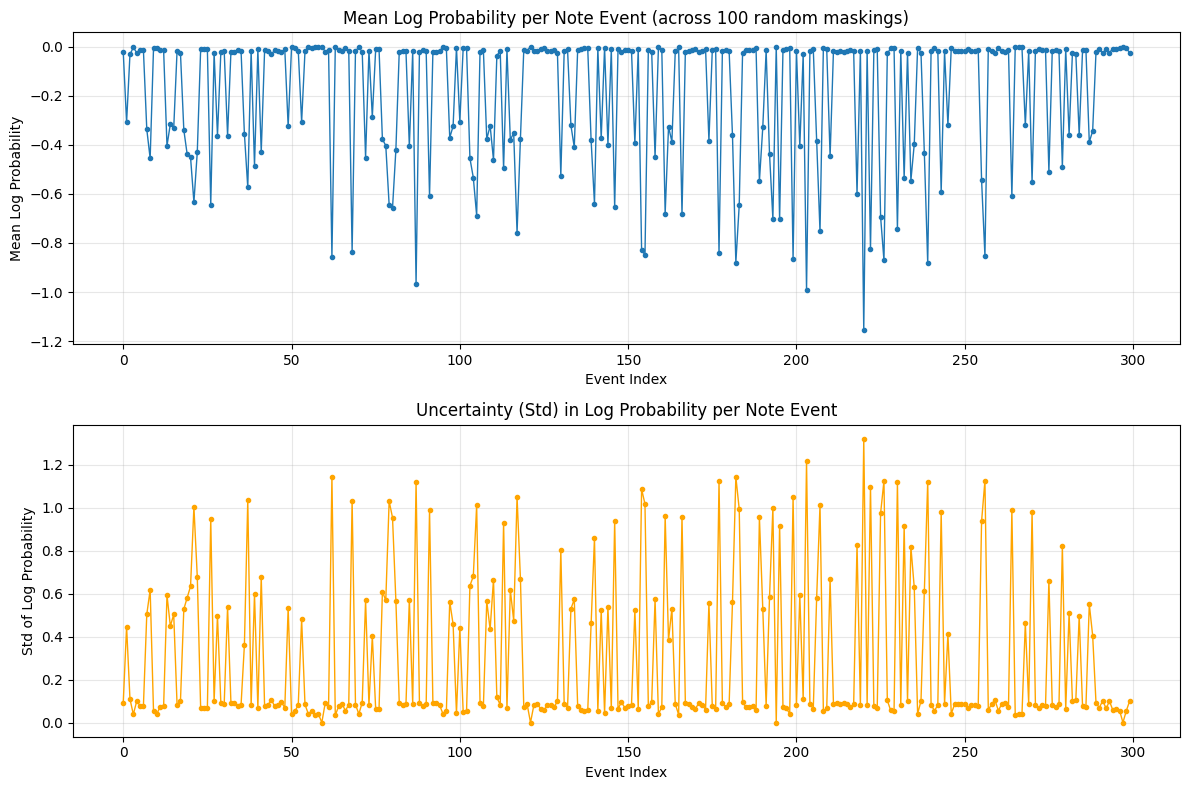

In [10]:
# Plot mean log probability for each event
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Mean log probability per event
axes[0].plot(event_mean_log_probs, marker='o', markersize=3, linewidth=1)
axes[0].set_xlabel('Event Index')
axes[0].set_ylabel('Mean Log Probability')
axes[0].set_title('Mean Log Probability per Note Event (across 100 random maskings)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Standard deviation of log probability per event
axes[1].plot(event_std_log_probs, marker='o', markersize=3, linewidth=1, color='orange')
axes[1].set_xlabel('Event Index')
axes[1].set_ylabel('Std of Log Probability')
axes[1].set_title('Uncertainty (Std) in Log Probability per Note Event')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


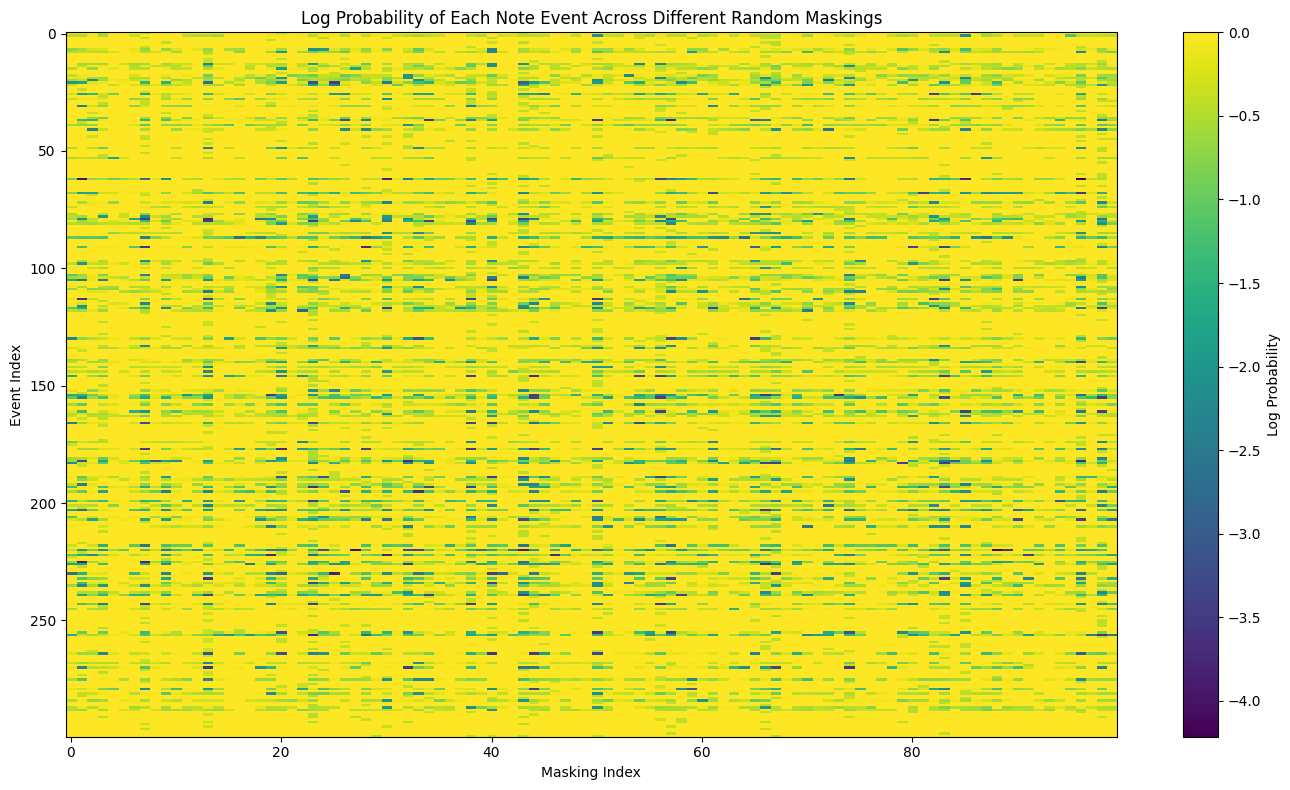

In [11]:
# Heatmap: log probability for each event across all maskings
fig, ax = plt.subplots(figsize=(14, 8))

# Average across attributes for visualization
event_log_probs = all_log_probs.mean(axis=2)  # Shape: (n_maskings, n_events)

im = ax.imshow(event_log_probs.T, aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_xlabel('Masking Index')
ax.set_ylabel('Event Index')
ax.set_title('Log Probability of Each Note Event Across Different Random Maskings')
plt.colorbar(im, ax=ax, label='Log Probability')
plt.tight_layout()
plt.show()


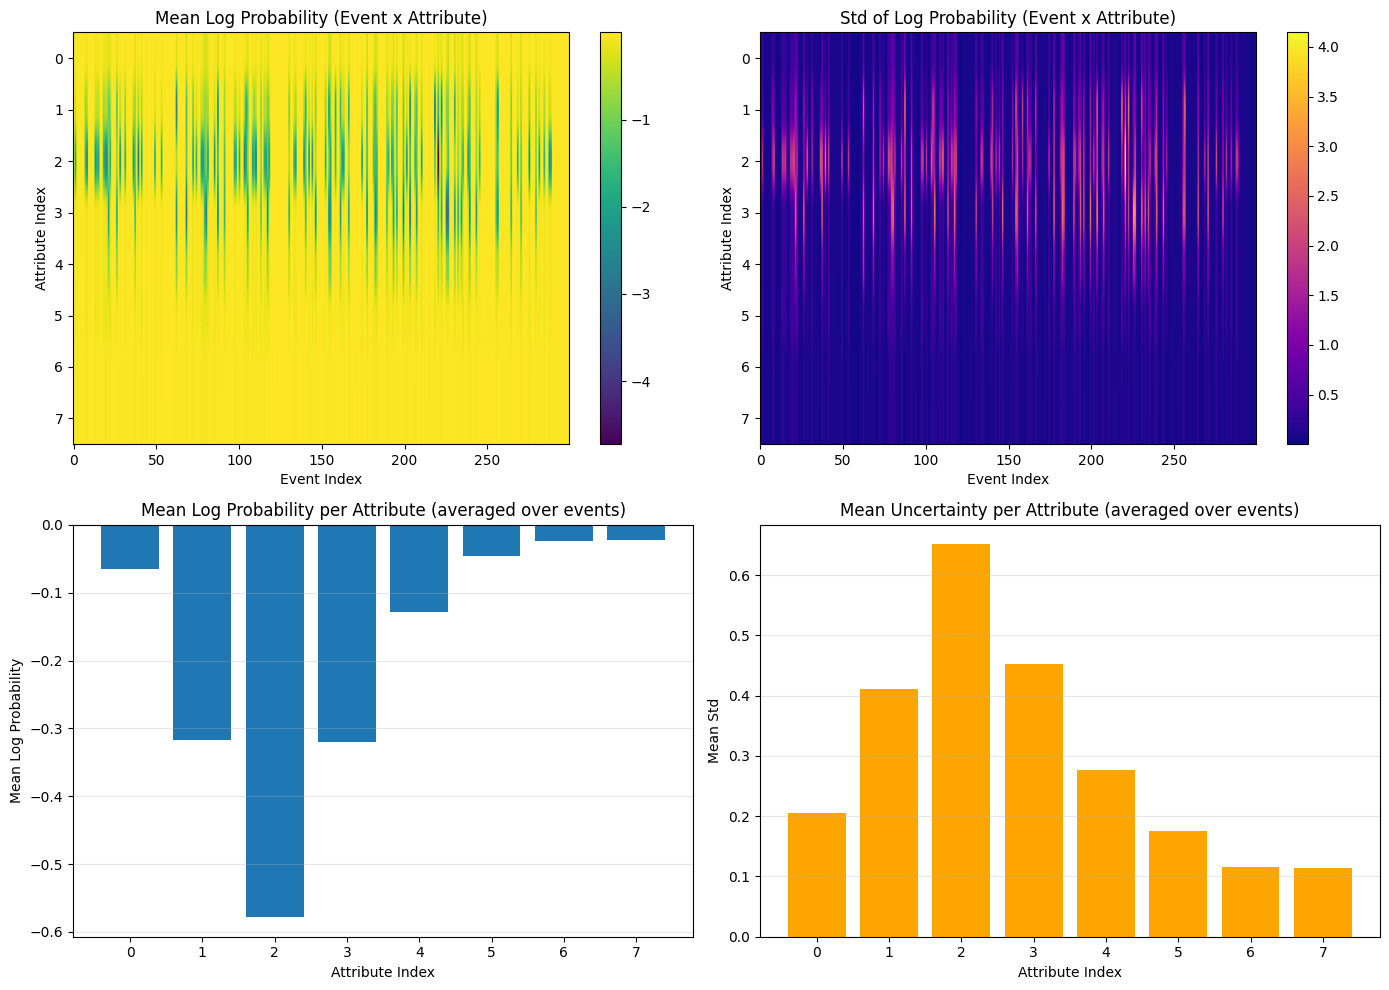

In [12]:
# Per-attribute analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean log prob heatmap
im0 = axes[0, 0].imshow(mean_log_probs.T, aspect='auto', cmap='viridis')
axes[0, 0].set_xlabel('Event Index')
axes[0, 0].set_ylabel('Attribute Index')
axes[0, 0].set_title('Mean Log Probability (Event x Attribute)')
plt.colorbar(im0, ax=axes[0, 0])

# Std heatmap
im1 = axes[0, 1].imshow(std_log_probs.T, aspect='auto', cmap='plasma')
axes[0, 1].set_xlabel('Event Index')
axes[0, 1].set_ylabel('Attribute Index')
axes[0, 1].set_title('Std of Log Probability (Event x Attribute)')
plt.colorbar(im1, ax=axes[0, 1])

# Per-attribute mean
attr_mean = mean_log_probs.mean(axis=0)
axes[1, 0].bar(range(len(attr_mean)), attr_mean)
axes[1, 0].set_xlabel('Attribute Index')
axes[1, 0].set_ylabel('Mean Log Probability')
axes[1, 0].set_title('Mean Log Probability per Attribute (averaged over events)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Per-attribute std
attr_std = std_log_probs.mean(axis=0)
axes[1, 1].bar(range(len(attr_std)), attr_std, color='orange')
axes[1, 1].set_xlabel('Attribute Index')
axes[1, 1].set_ylabel('Mean Std')
axes[1, 1].set_title('Mean Uncertainty per Attribute (averaged over events)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [13]:
# Print attribute names for reference
print("\\nAttribute indices correspond to:")
for i, attr in enumerate(tokenizer.note_attribute_order):
    print(f"  {i}: {attr}")


\nAttribute indices correspond to:
  0: instrument
  1: pitch
  2: onset/global_tick
  3: offset/global_tick
  4: duration
  5: velocity
  6: tag
  7: tempo


## Summary Statistics

In [14]:
# Find most and least certain events
most_certain_idx = event_std_log_probs.argmin()
least_certain_idx = event_std_log_probs.argmax()

print("\\nMost certain event (lowest std):")
print(f"  Event index: {most_certain_idx}")
print(f"  Mean log prob: {event_mean_log_probs[most_certain_idx]:.3f}")
print(f"  Std: {event_std_log_probs[most_certain_idx]:.3f}")

print("\\nLeast certain event (highest std):")
print(f"  Event index: {least_certain_idx}")
print(f"  Mean log prob: {event_mean_log_probs[least_certain_idx]:.3f}")
print(f"  Std: {event_std_log_probs[least_certain_idx]:.3f}")


\nMost certain event (lowest std):
  Event index: 121
  Mean log prob: -0.000
  Std: 0.000
\nLeast certain event (highest std):
  Event index: 220
  Mean log prob: -1.155
  Std: 1.319


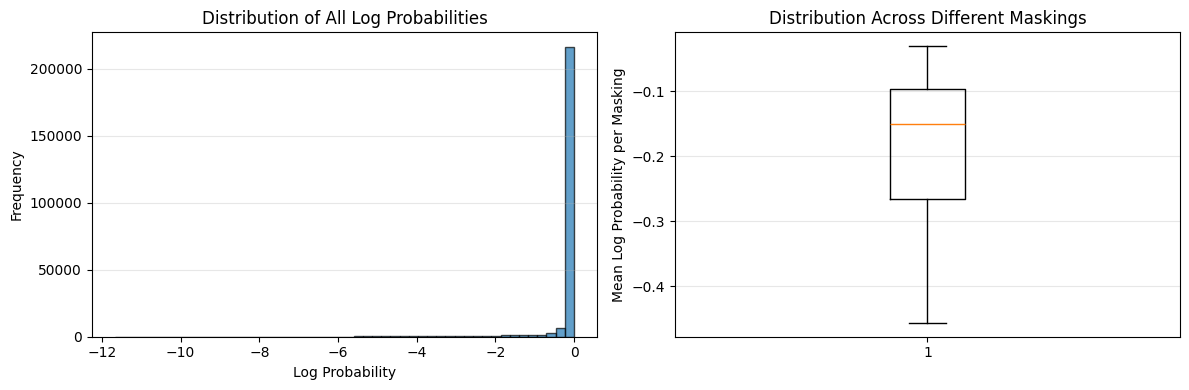

In [15]:
# Distribution of log probabilities across all maskings and events
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of all log probabilities
all_values = all_log_probs.flatten()
axes[0].hist(all_values, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Log Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Log Probabilities')
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot showing distribution across maskings
event_means_per_masking = all_log_probs.reshape(N_MASKINGS, -1).mean(axis=1)
axes[1].boxplot([event_means_per_masking])
axes[1].set_ylabel('Mean Log Probability per Masking')
axes[1].set_title('Distribution Across Different Maskings')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Adjust Note Velocities Based on Likelihood


In [16]:
# Convert log probabilities to velocities
# Use mean log probability across attributes for each event
event_log_probs_for_velocity = mean_log_probs.mean(axis=1)

# Convert log probs to probabilities
event_probs = np.exp(event_log_probs_for_velocity)

# Normalize to velocity range (20-127 to avoid silent notes)
min_velocity = 20
max_velocity = 127
velocity_range = max_velocity - min_velocity

# Normalize probabilities to [0, 1]
prob_min = event_probs.min()
prob_max = event_probs.max()
normalized_probs = (event_probs - prob_min) / (prob_max - prob_min)

# Map to velocity range
velocities = (normalized_probs * velocity_range + min_velocity).astype(int)

print(f"Velocity statistics:")
print(f"  Min velocity: {velocities.min()}")
print(f"  Max velocity: {velocities.max()}")
print(f"  Mean velocity: {velocities.mean():.1f}")
print(f"  Std velocity: {velocities.std():.1f}")


Velocity statistics:
  Min velocity: 20
  Max velocity: 127
  Mean velocity: 103.9
  Std velocity: 29.9


In [17]:
# Create a new Score with adjusted velocities
sm_adjusted = sm.copy()

# Get mapping from events to actual notes in the score
# Events are in the same order as they were extracted
note_idx = 0
for track in sm_adjusted.tracks:
    for note in track.notes:
        if note_idx < len(velocities):
            note.velocity = int(velocities[note_idx])
            note_idx += 1

print(f"Adjusted velocities for {note_idx} notes")

# Save the adjusted MIDI
adjusted_midi_path = "likelihood_adjusted_velocities.mid"
sm_adjusted.dump_midi(adjusted_midi_path)
print(f"Saved adjusted MIDI to: {adjusted_midi_path}")


Adjusted velocities for 102 notes
Saved adjusted MIDI to: likelihood_adjusted_velocities.mid


## Piano Roll Visualization


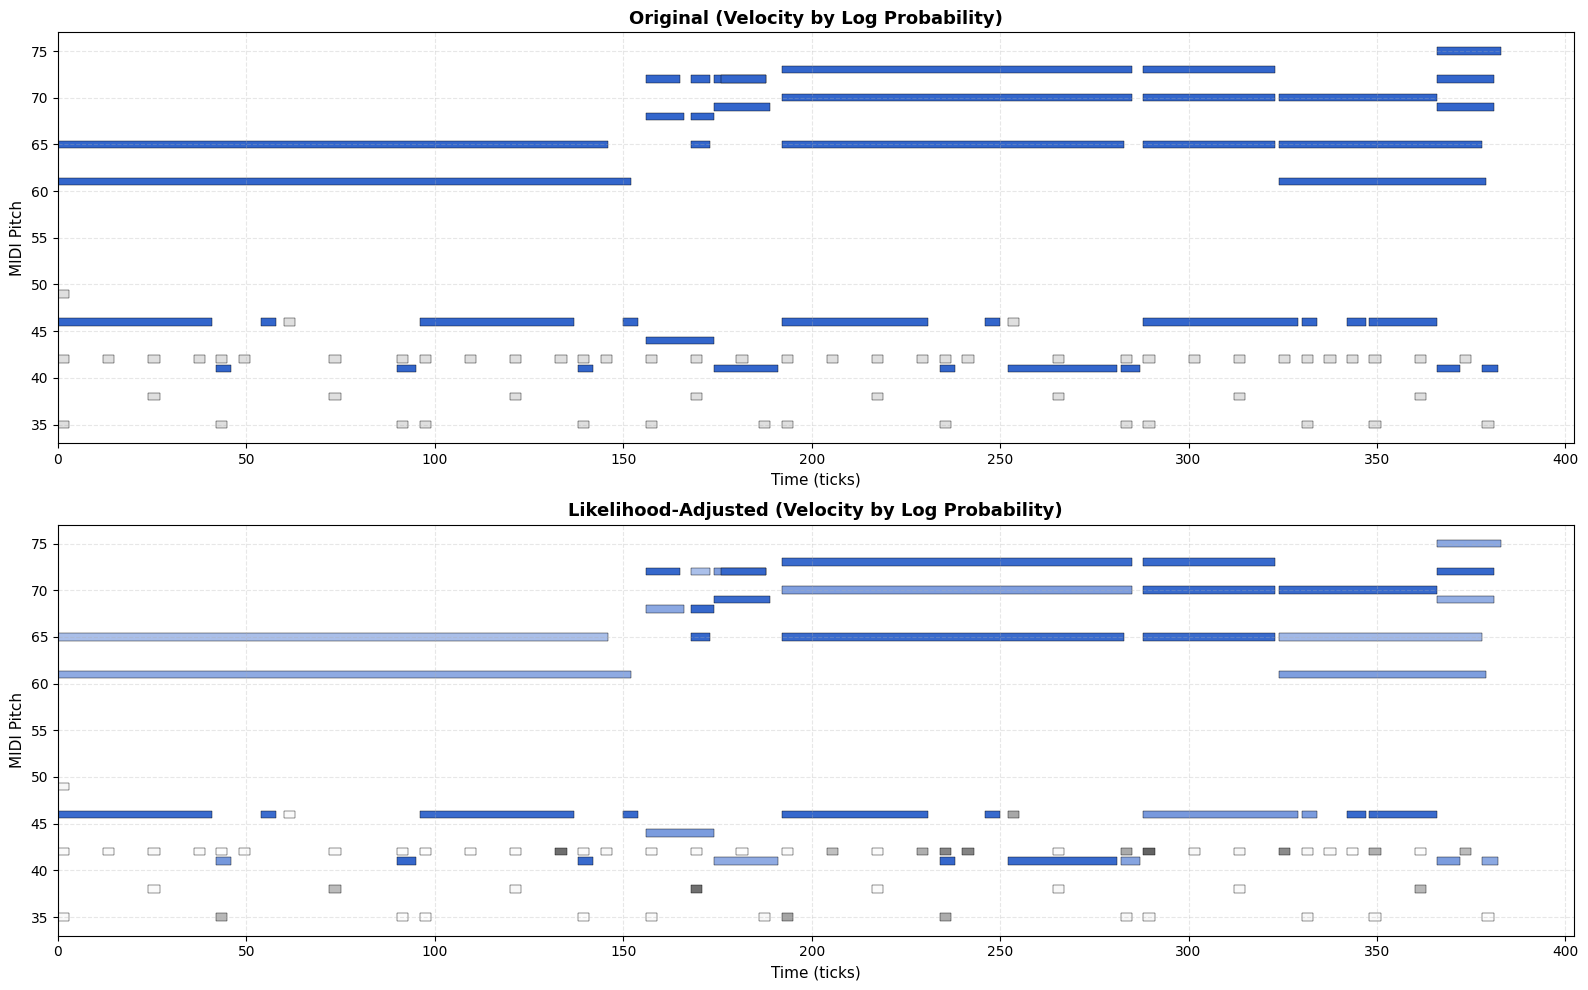

In [18]:
def plot_piano_roll_comparison(sm_original, sm_adjusted, title_suffix=""):
    """
    Plot piano rolls side by side for comparison.
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    for idx, (sm_plot, title) in enumerate([(sm_original, "Original"), (sm_adjusted, "Likelihood-Adjusted")]):
        ax = axes[idx]
        
        # Get all notes from all tracks
        notes_data = []
        for track_idx, track in enumerate(sm_plot.tracks):
            for note in track.notes:
                notes_data.append({
                    'pitch': note.pitch,
                    'start': note.time,
                    'end': note.time + note.duration,
                    'velocity': note.velocity,
                    'is_drum': track.is_drum
                })
        
        if not notes_data:
            continue
            
        # Plot melodic notes
        melodic_notes = [n for n in notes_data if not n['is_drum']]
        if melodic_notes:
            for note in melodic_notes:
                # Color based on velocity
                color_intensity = note['velocity'] / 127.0
                color = (0.2, 0.4, 0.8, color_intensity)
                ax.barh(note['pitch'], note['end'] - note['start'], 
                       left=note['start'], height=0.8,
                       color=color, edgecolor='black', linewidth=0.3)
        
        # Plot drum notes
        drum_notes = [n for n in notes_data if n['is_drum']]
        if drum_notes:
            for note in drum_notes:
                color_intensity = note['velocity'] / 127.0
                color = (color_intensity, color_intensity, color_intensity, 0.8)
                ax.barh(note['pitch'], note['end'] - note['start'],
                       left=note['start'], height=0.8,
                       color=color, edgecolor='black', linewidth=0.3)
        
        # Set labels and grid
        ax.set_xlabel('Time (ticks)', fontsize=11)
        ax.set_ylabel('MIDI Pitch', fontsize=11)
        ax.set_title(f'{title} {title_suffix}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Set reasonable y-limits
        all_pitches = [n['pitch'] for n in notes_data]
        if all_pitches:
            ax.set_ylim(min(all_pitches) - 2, max(all_pitches) + 2)
    
    plt.tight_layout()
    return fig

# Plot comparison
fig = plot_piano_roll_comparison(sm, sm_adjusted, title_suffix="(Velocity by Log Probability)")
plt.show()


In [ ]:
# Detailed view with uncertainty information
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Original piano roll
ax = axes[0]
for track_idx, track in enumerate(sm.tracks):
    for note in track.notes:
        color = (0.2, 0.4, 0.8, 0.7) if not track.is_drum else (0.1, 0.1, 0.1, 0.7)
        ax.barh(note.pitch, note.duration, left=note.time, height=0.8,
               color=color, edgecolor='black', linewidth=0.3)
ax.set_xlabel('Time (ticks)', fontsize=11)
ax.set_ylabel('MIDI Pitch', fontsize=11)
ax.set_title('Original (Uniform Velocity)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Velocity adjusted by mean log probability
ax = axes[1]
note_idx = 0
for track_idx, track in enumerate(sm_adjusted.tracks):
    for note in track.notes:
        if note_idx < len(velocities):
            color_intensity = note.velocity / 127.0
            color = (0.8, 0.2, 0.2, color_intensity) if not track.is_drum else (color_intensity, 0, 0, 0.8)
            ax.barh(note.pitch, note.duration, left=note.time, height=0.8,
                   color=color, edgecolor='black', linewidth=0.3)
            note_idx += 1
ax.set_xlabel('Time (ticks)', fontsize=11)
ax.set_ylabel('MIDI Pitch', fontsize=11)
ax.set_title('Likelihood-Adjusted Velocity (darker = higher probability)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

# Plot 3: Velocity adjusted by uncertainty (standard deviation)
ax = axes[2]
event_std_for_velocity = std_log_probs.mean(axis=1)
# Invert: higher std = lower velocity (more uncertain = quieter)
std_min = event_std_for_velocity.min()
std_max = event_std_for_velocity.max()
normalized_std = (event_std_for_velocity - std_min) / (std_max - std_min)
uncertainty_velocities = ((1 - normalized_std) * velocity_range + min_velocity).astype(int)

note_idx = 0
for track_idx, track in enumerate(sm.tracks):
    for note in track.notes:
        if note_idx < len(uncertainty_velocities):
            color_intensity = uncertainty_velocities[note_idx] / 127.0
            color = (0.2, 0.7, 0.3, color_intensity) if not track.is_drum else (0, color_intensity, 0, 0.8)
            ax.barh(note.pitch, note.duration, left=note.time, height=0.8,
                   color=color, edgecolor='black', linewidth=0.3)
            note_idx += 1
ax.set_xlabel('Time (ticks)', fontsize=11)
ax.set_ylabel('MIDI Pitch', fontsize=11)
ax.set_title('Certainty-Adjusted Velocity (darker = lower uncertainty)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


In [ ]:
# Save the uncertainty-adjusted version as well
sm_uncertainty = sm.copy()
note_idx = 0
for track in sm_uncertainty.tracks:
    for note in track.notes:
        if note_idx < len(uncertainty_velocities):
            note.velocity = int(uncertainty_velocities[note_idx])
            note_idx += 1

uncertainty_midi_path = "uncertainty_adjusted_velocities.mid"
sm_uncertainty.dump_midi(uncertainty_midi_path)
print(f"Saved uncertainty-adjusted MIDI to: {uncertainty_midi_path}")

print("\\nInterpretation:")
print("- Likelihood-adjusted: Notes with higher predicted probability are louder")
print("- Uncertainty-adjusted: Notes with lower variance across maskings are louder (more certain)")
